In [16]:
import glob
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import timedelta, datetime
#import contextily as ctx
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

jet = cm.get_cmap('jet', 256)
newcolors = jet(np.linspace(0.2, 1.0, 256))  # skip darkest 20%
lighter_jet = ListedColormap(newcolors)

/tmp/ipykernel_2808297/1887205310.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet', 256)


In [2]:
color_dict = {'lightblue': '#e9faff',
              'skyblue': '#8ce2ff',
              'ygreen': '#c3f448',
              'yellow': '#faff00',
              'yorange': '#ef0100',
              'maroon': '#690100'}

mycolorbar = LinearSegmentedColormap.from_list('mycolorbar', [
    color_dict['lightblue'],
    color_dict['skyblue'],
    color_dict['ygreen'],
    color_dict['yellow'],
    color_dict['yorange'],
])

In [3]:
dat = '20190915'
dat1 = '2019-09-15-03600'
dat2 = '2019-09-16-03600'
workdir = '/home/svisaga/MUSICA_ANALYSES/WWW-AIR_1726704979598/'
p3file = f'CAMP2Ex-mrg01-P3B-NC_merge_{dat}_R3.nc'
p3data_ds = xarray.open_dataset(workdir+p3file)
p3data_ds
variables = ['Org_Ave_IsoK_STP', 'mz42_Ave_IsoK_STP', 'mz43_Ave_IsoK_STP', 'mz44_Ave_IsoK_STP', 'mz60_Ave_IsoK_STP']
selected_data = p3data_ds[variables]
p3data = selected_data.to_dataframe().reset_index()

In [4]:

df = p3data
df = df[df['Org_Ave_IsoK_STP']>=40]
# Southwesternmost point: minimum latitude + minimum longitude
sw_point = df.loc[df.assign(
    lat_rank=df['lat'].rank(method='min'),
    lon_rank=df['lon'].rank(method='min')
).eval('lat_rank + lon_rank').idxmin()]

# Southeasternmost point: minimum latitude + maximum longitude
se_point = df.loc[df.assign(
    lat_rank=df['lat'].rank(method='min'),
    lon_rank=-df['lon'].rank(method='min')  # negate to rank max lon
).eval('lat_rank + lon_rank').idxmin()]

print("Southwesternmost point:\n", sw_point)
print("\nSoutheasternmost point:\n", se_point)


Southwesternmost point:
 time                 2019-09-16 01:45:23.500000
Org_Ave_IsoK_STP                         40.209
mz42_Ave_IsoK_STP                         1.595
mz43_Ave_IsoK_STP                         3.286
mz44_Ave_IsoK_STP                         5.736
mz60_Ave_IsoK_STP                          0.31
lat                                    8.112029
lon                                  117.444199
alt                                  791.200012
Name: 13816, dtype: object

Southeasternmost point:
 time                 2019-09-16 01:14:37.500000
Org_Ave_IsoK_STP                         41.195
mz42_Ave_IsoK_STP                         1.516
mz43_Ave_IsoK_STP                         3.383
mz44_Ave_IsoK_STP                         5.753
mz60_Ave_IsoK_STP                         0.273
lat                                    7.522913
lon                                  119.009636
alt                                       318.5
Name: 11970, dtype: object


In [5]:
longitude_min = 94
longitude_max = 140
latitude_min = -11  # Adjust as necessary
latitude_max = 20   # Adjust as necessary

In [6]:
ds_MERRA2_wind = xarray.open_mfdataset("/ships22/raqms/svisaga/MERRA2_T_U_V_Q_2025/MERRA2_TUVQ_SEAcut_25km_2019-09-16-00000.nc")
ds_MERRA2_wind_mean = ds_MERRA2_wind

In [7]:
# Constants
P0 = 101325 #101325  # sea-level pressure in Pa
T0 = 288.15  # standard temperature in K
g = 9.80665  # gravity in m/s^2
R = 287.05   # specific gas constant for dry air in J/(kg·K)

# Convert pressure to Pa
pressure_pa = ds_MERRA2_wind_mean['lev'] * 100

# Compute altitude (meters)
altitude = (T0 / (g / R)) * np.log(P0 / pressure_pa)
altitude.values


array([47468.80148339, 41273.45496815, 35902.87128374, 31356.45341058,
       28167.04714476, 26612.48831877, 25099.97086403, 23629.44620058,
       22100.08568465, 20627.35709664, 19256.76458874, 17886.17081302,
       16515.57787547, 15144.98434463, 13774.39126038, 12403.79792213,
       11033.20411662,  9662.610254  ,  8292.01745596,  6921.42402195,
        5550.83039977,  4283.18850479,  3223.76478057,  2388.04131574,
        1776.01668816,  1387.69064155,  1122.20426998,   882.00306074,
         667.08549705,   477.45359621,   313.10562822,   174.0421484 ])

In [8]:
ds_MERRA2_wind_mean = ds_MERRA2_wind_mean.assign_coords(altitude=("lev", altitude.values))

In [9]:
ds_wind = xarray.open_mfdataset("/home/svisaga/MUSICA_ANALYSES/MUSICAv0_AOD_U_V_regridded/MUSICAv0_complete_SEAcut_25km_2019-09-16*.nc")
ds_wind_mean = ds_wind.isel(time=1)

In [10]:
# Assuming your DataArray is named `da` and has dimensions ('lat', 'lon', 'alt')

# Step 1: Select latitude (exact match or nearest)
da_lat_slice = ds_wind_mean.sel(lat=7.5, method='nearest')  # or use method='pad'/'backfill' if needed

# Step 2: Slice longitude range
transect = da_lat_slice.sel(lon=slice(117, 121))  # keeps all altitudes

# Now `transect` has dimensions ('lon', 'alt') — a vertical slice at lat=7.5
transect

<xarray.Dataset>
Dimensions:  (lon: 16, lev: 32)
Coordinates:
    lat      float32 7.385
  * lon      (lon) float32 117.2 117.5 117.7 118.0 ... 120.2 120.5 120.7 121.0
  * lev      (lev) float32 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
    time     datetime64[ns] 2019-09-16T01:30:00
Data variables: (12/15)
    AODVIS   (lon) float32 dask.array<chunksize=(16,), meta=np.ndarray>
    U        (lon, lev) float32 dask.array<chunksize=(16, 32), meta=np.ndarray>
    V        (lon, lev) float32 dask.array<chunksize=(16, 32), meta=np.ndarray>
    T        (lon, lev) float32 dask.array<chunksize=(16, 32), meta=np.ndarray>
    Q        (lon, lev) float32 dask.array<chunksize=(16, 32), meta=np.ndarray>
    bc_a1    (lon, lev) float32 dask.array<chunksize=(16, 32), meta=np.ndarray>
    ...       ...
    soa_a1   (lon, lev) float32 dask.array<chunksize=(16, 32), meta=np.ndarray>
    soa_a2   (lon, lev) float32 dask.array<chunksize=(16, 32), meta=np.ndarray>
    so4_a1   (lon, lev) float32 dask.array<chunksize=(16, 32), meta=np.ndarray>
    so4_a2   (lon, lev) float32 dask.array<chunksize=(16, 32), meta=np.ndarray>
    so4_a3   (lon, lev) float32 dask.array<chunksize=(16, 32), meta=np.ndarray>
    Z3       (lon, lev) float32 dask.array<chunksize=(16, 32), meta=np.ndarray>

In [11]:
#MUSICAv0 in kg/kg
#to P3 ug/m3
# rho_air = 1.225 kg m-3 at STP
p3_ug_m3 = 1.225*1000*1E6

########################################################################
########################################################################
########################################################################
oa_model = p3_ug_m3*(transect['pom_a1'] + transect['pom_a4'] + transect['soa_a1'] + transect['soa_a2'])


In [12]:
# Constants
P0 = 101325 #101325  # sea-level pressure in Pa
T0 = 288.15  # standard temperature in K
g = 9.80665  # gravity in m/s^2
R = 287.05   # specific gas constant for dry air in J/(kg·K)

# Convert pressure to Pa
pressure_pa = ds_wind_mean['lev'] * 100

# Compute altitude (meters)
altitude = (T0 / (g / R)) * np.log(P0 / pressure_pa)

In [13]:
ds_wind_mean = ds_wind_mean.assign_coords(altitude=("lev", altitude.values))
ds_wind_mean

<xarray.Dataset>
Dimensions:   (lat: 158, lon: 186, lev: 32)
Coordinates:
  * lat       (lat) float32 -19.15 -18.9 -18.65 -18.4 ... 19.4 19.65 19.9 20.15
  * lon       (lon) float32 93.94 94.19 94.44 94.69 ... 139.5 139.7 140.0 140.2
  * lev       (lev) float32 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
    time      datetime64[ns] 2019-09-16T01:30:00
    altitude  (lev) float64 4.747e+04 4.127e+04 3.59e+04 ... 477.5 313.1 174.0
Data variables: (12/15)
    AODVIS    (lat, lon) float32 dask.array<chunksize=(158, 186), meta=np.ndarray>
    U         (lat, lon, lev) float32 dask.array<chunksize=(158, 186, 32), meta=np.ndarray>
    V         (lat, lon, lev) float32 dask.array<chunksize=(158, 186, 32), meta=np.ndarray>
    T         (lat, lon, lev) float32 dask.array<chunksize=(158, 186, 32), meta=np.ndarray>
    Q         (lat, lon, lev) float32 dask.array<chunksize=(158, 186, 32), meta=np.ndarray>
    bc_a1     (lat, lon, lev) float32 dask.array<chunksize=(158, 186, 32), meta=np.ndarray>
    ...        ...
    soa_a1    (lat, lon, lev) float32 dask.array<chunksize=(158, 186, 32), meta=np.ndarray>
    soa_a2    (lat, lon, lev) float32 dask.array<chunksize=(158, 186, 32), meta=np.ndarray>
    so4_a1    (lat, lon, lev) float32 dask.array<chunksize=(158, 186, 32), meta=np.ndarray>
    so4_a2    (lat, lon, lev) float32 dask.array<chunksize=(158, 186, 32), meta=np.ndarray>
    so4_a3    (lat, lon, lev) float32 dask.array<chunksize=(158, 186, 32), meta=np.ndarray>
    Z3        (lat, lon, lev) float32 dask.array<chunksize=(158, 186, 32), meta=np.ndarray>

In [14]:
#add winds
ds_zbot = xarray.open_mfdataset("/home/svisaga/MUSICA_ANALYSES/MUSICAv0_regrid/FINNpeatSM_0.36BA_MUSICAv0_AOD_U_V/MUSICAv0_PHIS_SEAcut_25km_2019-08-31-03600.nc")
ds_zbot = ds_zbot.mean(dim="time")
ds_zbot['PHIS'].values

array([[   0.     ,    0.     ,    0.     , ..., 1668.727  , 1035.2899 ,
         746.6281 ],
       [   0.     ,    0.     ,    0.     , ...,  737.3703 , 1035.2899 ,
         746.6281 ],
       [   0.     ,    0.     ,    0.     , ...,  737.3703 ,  454.98816,
         388.6327 ],
       ...,
       [1271.547  , 3738.3594 , 6234.307  , ...,    0.     ,    0.     ,
           0.     ],
       [1066.5703 , 5143.3525 , 6136.0815 , ...,    0.     ,    0.     ,
           0.     ],
       [3501.696  , 5913.7935 , 4412.3413 , ...,    0.     ,    0.     ,
           0.     ]], dtype=float32)

/tmp/ipykernel_2808297/3994619559.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(lighter_jet).copy()
/tmp/ipykernel_2808297/3994619559.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(lighter_jet).copy()


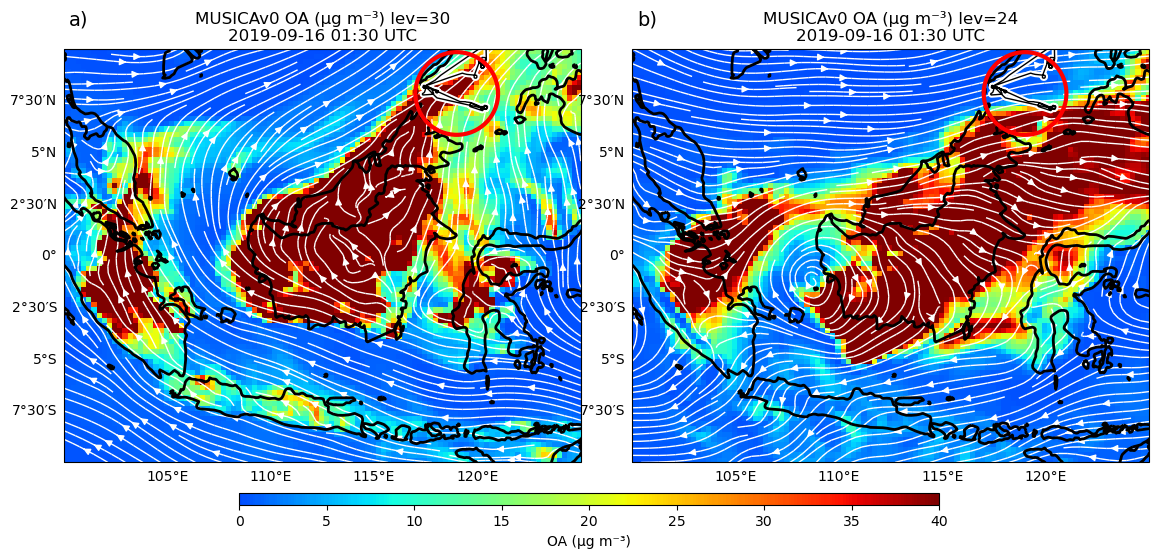

In [38]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cf
import pandas as pd
from matplotlib import cm

# Define levels you want to plot
levels = [30, 24]
# Panel label: 'a)' for first, 'b)' for second
panel_labels = ['a)', 'b)']


fig = plt.figure(figsize=(14, 6))  # wider for two panels
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

pla_proj = ccrs.PlateCarree()
axes = []

# Loop over lev values and plot each panel
for i, lev in enumerate(levels):
    ds_wind_ = ds_wind_mean.isel(lev=lev)
    alt_4d = ds_wind_['altitude'].broadcast_like(ds_wind_['U'])
    #ds_wind_ = ds_wind_.where((ds_zbot['PHIS']/9.8) < 900, np.nan)

    ax = fig.add_subplot(gs[i], projection=pla_proj)
    axes.append(ax)

    ax.set_extent([100, 125, -10, 10], crs=ccrs.PlateCarree())

    # conversion factor
    p3_ug_m3 = 1.225 * 1000 * 1E6
    oa_model = p3_ug_m3 * (ds_wind_['pom_a1'] + ds_wind_['pom_a4'] +
                           ds_wind_['soa_a1'] + ds_wind_['soa_a2'])

    cmap = cm.get_cmap(lighter_jet).copy()
    cmap.set_bad(color='k')

    # Use panel_labels[i] instead of hard-coded 'a)'
    ax.text(0.01, 1.05, panel_labels[i], transform=ax.transAxes,
            fontsize=14, va='bottom', ha='left')
    # Plot OA field
    ref = oa_model.plot.pcolormesh(vmin=0, vmax=40, cmap=cmap,
                                   ax=ax, add_colorbar=False)

    # Overlay winds
    ds_wind_.plot.streamplot('lon','lat','U','V', color='white',
                             linewidth=1, density=2, ax=ax, zorder=1)

    # Coastlines and borders
    ax.coastlines(resolution='50m', color='black', linewidth=2)
    ax.add_feature(cf.BORDERS, linewidth=2, edgecolor='black', zorder=2)

    # Flight track
    ax.plot(p3data['lon'], p3data['lat'], color='white', lw=4,
            transform=ccrs.PlateCarree(), label='Flight Track')
    ax.plot(p3data['lon'], p3data['lat'], color='k', lw=1,
            transform=ccrs.PlateCarree(), label='Flight Track')
    # Compute center of the flight track
    center_lon = 119#np.mean(p3data['lon'].values)
    center_lat = 7.85#np.mean(p3data['lat'].values)
    # Add a big red circle over the whole track
    big_circle = mpatches.Circle((center_lon, center_lat),
                                radius=2,   # adjust radius in degrees
                                transform=ccrs.PlateCarree(),
                                facecolor='none', edgecolor='red',
                                linewidth=3, zorder=4)
    ax.add_patch(big_circle)
    # Gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlines = False
    gl.ylines = False
    gl.right_labels = False
    gl.top_labels = False

    # Title
    time_str = pd.to_datetime(ds_wind_.time.values).strftime('%Y-%m-%d %H:%M UTC')
    ax.set_title(f'MUSICAv0 OA (µg m⁻³) lev={lev}\n{time_str}')

# Shared colorbar
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # centered below both panels
plt.colorbar(ref, cax=cbar_ax, orientation='horizontal', label='OA (µg m⁻³)')

# Save figure
time_str = pd.to_datetime(ds_wind_.time.values).strftime('%Y-%m-%d_%H_%M_')
plt.savefig(f'img/Figure11_AMSPaper.png',
            dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_2808297/2679672507.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(lighter_jet).copy()
/tmp/ipykernel_2808297/2679672507.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(lighter_jet).copy()


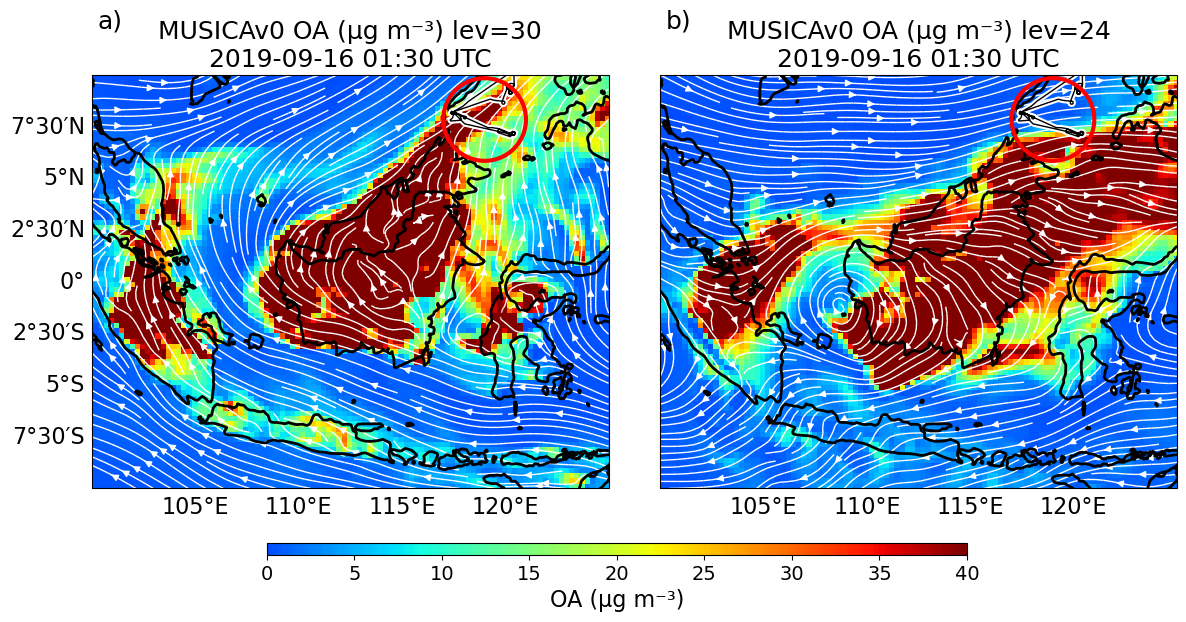

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cf
import pandas as pd
from matplotlib import cm
import matplotlib.patches as mpatches

# Define levels you want to plot
levels = [30, 24]
panel_labels = ['a)', 'b)']

# Global font size settings
plt.rcParams.update({
    'font.size': 16,          # base font size
    'axes.titlesize': 18,     # title size
    'axes.labelsize': 16,     # axis label size
    'xtick.labelsize': 14,    # x tick labels
    'ytick.labelsize': 14,    # y tick labels
    'legend.fontsize': 14,    # legend
    'figure.titlesize': 20    # figure title
})

fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

pla_proj = ccrs.PlateCarree()
axes = []

for i, lev in enumerate(levels):
    ds_wind_ = ds_wind_mean.isel(lev=lev)
    alt_4d = ds_wind_['altitude'].broadcast_like(ds_wind_['U'])

    ax = fig.add_subplot(gs[i], projection=pla_proj)
    axes.append(ax)

    ax.set_extent([100, 125, -10, 10], crs=ccrs.PlateCarree())

    # conversion factor
    p3_ug_m3 = 1.225 * 1000 * 1E6
    oa_model = p3_ug_m3 * (ds_wind_['pom_a1'] + ds_wind_['pom_a4'] +
                           ds_wind_['soa_a1'] + ds_wind_['soa_a2'])

    cmap = cm.get_cmap(lighter_jet).copy()
    cmap.set_bad(color='k')

    ax.text(0.01, 1.1, panel_labels[i], transform=ax.transAxes,
            fontsize=18, va='bottom', ha='left')

    ref = oa_model.plot.pcolormesh(vmin=0, vmax=40, cmap=cmap,
                                   ax=ax, add_colorbar=False)

    ds_wind_.plot.streamplot('lon','lat','U','V', color='white',
                             linewidth=1, density=2, ax=ax, zorder=1)

    ax.coastlines(resolution='50m', color='black', linewidth=2)
    ax.add_feature(cf.BORDERS, linewidth=2, edgecolor='black', zorder=2)

    ax.plot(p3data['lon'], p3data['lat'], color='white', lw=4,
            transform=ccrs.PlateCarree())
    ax.plot(p3data['lon'], p3data['lat'], color='k', lw=1,
            transform=ccrs.PlateCarree())

    center_lon = 119
    center_lat = 7.85
    big_circle = mpatches.Circle((center_lon, center_lat),
                                radius=2,
                                transform=ccrs.PlateCarree(),
                                facecolor='none', edgecolor='red',
                                linewidth=3, zorder=4)
    ax.add_patch(big_circle)

    # inside your loop, after creating gl = ax.gridlines(...)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlines = False
    gl.ylines = False
    gl.right_labels = False
    gl.top_labels = False

    # Remove y-axis labels for panel B (lev=24)
    if i == 1:
        gl.left_labels = False

    time_str = pd.to_datetime(ds_wind_.time.values).strftime('%Y-%m-%d %H:%M UTC')
    ax.set_title(f'MUSICAv0 OA (µg m⁻³) lev={lev}\n{time_str}', fontsize=18)

# Shared colorbar
cbar_ax = fig.add_axes([0.25, 0.04, 0.5, 0.02])
cbar = plt.colorbar(ref, cax=cbar_ax, orientation='horizontal', label='OA (µg m⁻³)')
cbar.ax.tick_params(labelsize=14)  # enlarge colorbar tick labels
cbar.set_label('OA (µg m⁻³)', fontsize=16)

time_str = pd.to_datetime(ds_wind_.time.values).strftime('%Y-%m-%d_%H_%M_')
plt.savefig(f'img/Figure11_AMSPaper.png', dpi=300, bbox_inches='tight')
plt.show()
